# Simulaciones proyecto

En este notebook se desarrollan las simulaciones relacionadas al paper ...

Se busca probar los tests de hipótesis relacionados a la norma $L_1$ y la de $log$-Likelihood.

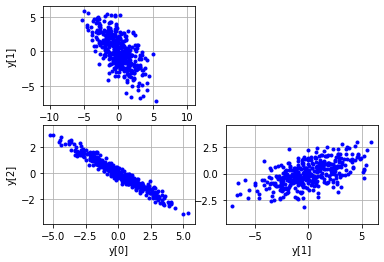

In [1]:
# generacion de datos
"""Example of generating correlated normally distributed random samples."""

import numpy as np
from scipy.linalg import eigh, cholesky
from scipy.stats import norm

from pylab import plot, show, axis, subplot, xlabel, ylabel, grid


# Choice of cholesky or eigenvector method.
method = 'cholesky'
#method = 'eigenvectors'

num_samples = 400

# The desired covariance matrix.
r = np.array([
        [  3.40, -2.75, -2.00],
        [ -2.75,  5.50,  1.50],
        [ -2.00,  1.50,  1.25]
    ])

# Generate samples from three independent normally distributed random
# variables (with mean 0 and std. dev. 1).
x = norm.rvs(size=(3, num_samples))

# We need a matrix `c` for which `c*c^T = r`.  We can use, for example,
# the Cholesky decomposition, or the we can construct `c` from the
# eigenvectors and eigenvalues.

if method == 'cholesky':
    # Compute the Cholesky decomposition.
    c = cholesky(r, lower=True)
else:
    # Compute the eigenvalues and eigenvectors.
    evals, evecs = eigh(r)
    # Construct c, so c*c^T = r.
    c = np.dot(evecs, np.diag(np.sqrt(evals)))

# Convert the data to correlated random variables. 
y = np.dot(c, x)

#
# Plot various projections of the samples.
#
subplot(2,2,1)
plot(y[0], y[1], 'b.')
ylabel('y[1]')
axis('equal')
grid(True)

subplot(2,2,3)
plot(y[0], y[2], 'b.')
xlabel('y[0]')
ylabel('y[2]')
axis('equal')
grid(True)

subplot(2,2,4)
plot(y[1], y[2], 'b.')
xlabel('y[1]')
axis('equal')
grid(True)

show()

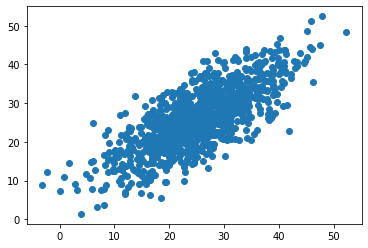

In [8]:
import numpy as np
from matplotlib.pyplot import scatter

xx = np.array([-0.51, 51.2])
yy = np.array([0.33, 51.6])
means = [xx.mean(), yy.mean()]  
stds = [xx.std() / 3, yy.std() / 3]
corr = 0.8         # correlation
covs = [[stds[0]**2          , stds[0]*stds[1]*corr], 
        [stds[0]*stds[1]*corr,           stds[1]**2]] 

m = np.random.multivariate_normal(means, covs, 1000).T
scatter(m[0], m[1])


In [ ]:
# setear parametros
Dimensiones = [1, 2, 3]
# samplear n muestras de dos variables aleatorias independientes desde las sgtes distribuciones
# super-Gaussian
# sub-Gaussian
# multimodal
# unimodal
# centradas en cero y varianza unitaria

# mezclar los datos con una matriz de rotacion parametrizada por un angulo theta desde 0 a pi/4

# para las dimensiones d = {2, 3} ruido gaussiano centrado en cero y con varianza unitaria

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
(10000,) (10000,)


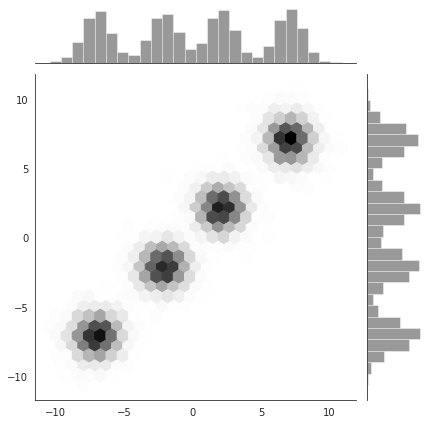

In [132]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

d = 1
n_samples = 10000
X = np.array([np.random.normal(loc=-10, size=2500),
              np.random.normal(loc=-3, size=2500),
              np.random.normal(loc=3, size=2500),
              np.random.normal(loc=10, size=2500)]).reshape((n_samples,))

# Y = np.array([np.random.normal(loc=-5, size=5000), np.random.normal(loc=5, size=5000)]).reshape((n_samples,))
# X = np.array([np.random.normal(loc=-5, size=5000), np.random.normal(loc=5, size=5000)]).reshape((n_samples,))
Y = np.array([np.random.normal(size=5000), np.random.normal(size=5000)]).reshape((n_samples,))
# Y = np.zeros((n_samples,))

theta = (np.pi / 4) * 1

rotationMatrix = np.array([[np.cos(theta), -np.sin(theta)],
                           [np.sin(theta), np.cos(theta)]])

print(rotationMatrix)
print(X.shape, Y.shape)

[X, Y] = rotationMatrix @ [X, Y]

with sns.axes_style("white"):
    sns.jointplot(x=X, y=Y, kind="hex", color="k");

## Estadístico basado en norma $L_1$

Primero se calcula el test basado en la norma $L_1$. Donde su formulación es:

$$
    L_1(\nu_n, \ \mu_{n,1} \times \mu_{n,2}) =
    \sum_{A\in P_n}\sum_{B\in Q_n} |\nu_n(A\times B) - \mu_{n,1}(A) \cdot \mu_{n,2}(B)|
$$
    
Donde se tiene que dicho estadístico sobrepasa un umbral dado por el test de hipótesis, que está dado por

$$
    L_{n}(\nu_{n}, \mu_{n,1}\times\mu_{n,2})>  c_{1}\left(\sqrt{\frac{m_{n} \cdot m'_{n}}{n}} + \sqrt{\frac{m_{n}}{n}} + \sqrt{\frac{m'_{n}}{n}}\right)  \approx c_{1}\sqrt{\frac{m_{n} \cdot m'_{n}}{n}}
$$

-10.440691778363195 10.896269433859096 21.336961212222292
-10.651967166037483 10.754197169108952 21.406164335146435


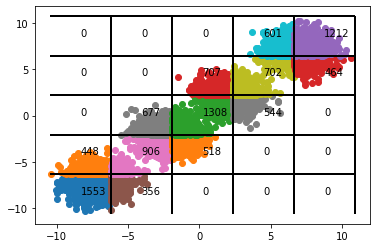

In [133]:
# particionar el espacio y generar los soportes, es decir, los intervalos sobre los que se sumara
mX = 5
mY = 5
minx = np.min(X)
maxx = np.max(X)
dx = maxx - minx
print(minx,maxx,dx)

miny = np.min(Y)
maxy = np.max(Y)
dy = maxy - miny
print(miny,maxy,dy)

for mx in range(mX):
    ax, bx = [minx + dx * mx / mX,
              minx + dx * (mx + 1) / mX] # se define intervalo de la particion
    for my in range(mY):
        ay, by = [miny + dy * my / mY,
                  miny + dy * (my + 1) / mY] # se define intervalo de la particion
        
        intervaloX = np.array([X < bx]) * np.array([X > ax])
        intervaloY = np.array([Y < by]) * np.array([Y > ay])
        cx = np.sum(intervaloX[0] * intervaloY[0])
        
        plt.scatter(x=X[intervaloX[0] * intervaloY[0]], y=Y[intervaloX[0] * intervaloY[0]], cmap="PuOr")
        plt.vlines(bx, ymin=miny, ymax=maxy)
        plt.hlines(by, xmin=minx, xmax=maxx)
        plt.text((ax + bx)/2, (ay + by)/2, str(cx))

# calcular el estadístico
L1 = 0